## Introduction

This notebook gives an introduction to `pandana`, the network-based accessibility calculator used in UrbanSim, in the context of the Bay Area UrbanSim model.   Pandana is a general-purpose network aggregation library and can be used for non-UrbanSim use cases as well.  For additional information, see the documentation here:  https://github.com/UDST/pandana

In [1]:
%%capture
%matplotlib notebook
%matplotlib inline
import pandana as pdna
from urbansim.utils import misc

from ipywidgets import interact
from ipywidgets import FloatSlider

from bokeh.io import output_notebook, show
from bokeh.plotting import Figure
from datashader.bokeh_ext import create_ramp_legend, create_categorical_legend

output_notebook()

import datashader.transfer_functions as tf

import datashader as ds
from datashader.colors import viridis

import orca

from bayarea import datasources
from bayarea import variables
from bayarea import models

def visualize_parcel_variable(var_name):
    parcels = orca.get_table('parcels').to_frame(['x', 'y', var_name])

    cvs = ds.Canvas(plot_width=700, plot_height=500)
    agg = cvs.points(parcels, 'x', 'y', ds.mean(var_name))
    img = tf.set_background(tf.shade(agg, cmap=viridis),"white")
    return img

def hh_network_access_plot(table_var_name, distance, agg_function, decay):
    network.set(households.node_id, variable = households[table_var_name].astype('float'))
    results = network.aggregate(distance, type=agg_function, decay=decay)

    access_var_name = '_'.join([agg_function, table_var_name, str(distance), decay])
    parcels[access_var_name] = misc.reindex(results, parcels.node_id)

    cvs = ds.Canvas(plot_width=700, plot_height=500)
    agg = cvs.points(parcels, 'x', 'y', ds.mean(access_var_name))
    img = tf.set_background(tf.shade(agg, cmap=viridis),"white")
    return img

orca.run(['build_networks'])

ModuleNotFoundError: No module named 'bayarea'

## Existing Bay Area network-based accessibility variables

In [2]:
num_pandana_vars = len([col for col in orca.get_table('parcels').columns if ('_flat' in col) or ('_linear' in col)])
print('There are %s currently defined variables utilizing pandana' % num_pandana_vars)

There are 1063 currently defined variables utilizing pandana


Calculating number of jobs for parcels


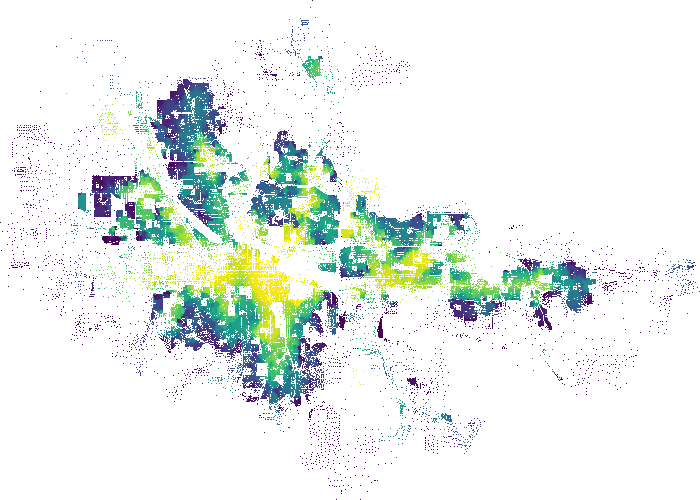

In [3]:
visualize_parcel_variable('total_jobs_sum_800_flat')

## Exploring network query parameters

In [4]:
hh_numeric_cols = ['persons', 'income', 'tenure', 'cars', 'race_of_head', 'age_of_head','workers', 'children', 'recent_mover']
parcels = orca.get_table('parcels').local
network = orca.get_injectable('net')

households = orca.get_table('households').to_frame(['persons', 'income', 'tenure', 'cars', 'race_of_head',
                                                    'age_of_head','workers', 'children', 'recent_mover', 'node_id'])

In [5]:

interact(hh_network_access_plot, table_var_name=hh_numeric_cols, distance=FloatSlider(min=200, max=5000, step=100, continuous_update=False), agg_function=['sum', 'ave', 'std'], decay=['flat', 'linear'])

interactive(children=(Dropdown(description='table_var_name', options=('persons', 'income', 'tenure', 'cars', '…

<function __main__.hh_network_access_plot(table_var_name, distance, agg_function, decay)>

## Detailed example

In [6]:
# Read model data
parcels = orca.get_table('parcels').local
buildings = orca.get_table('buildings').local
parcels['total_du'] = buildings.groupby('parcel_id').residential_units.sum()
parcels.total_du = parcels.total_du.fillna(0)

# Read network edges and nodes
edges = orca.get_table('edges').local
nodes = orca.get_table('nodes').local

In [7]:
print(nodes.head())
print(edges.head())
print(parcels[['x', 'y']].head())

                   x          y
node_id                        
36765374 -123.538985  44.281343
36765619 -123.556068  44.286023
36765620 -123.555613  44.285932
36765629 -123.549799  44.286514
36769378 -123.553713  44.281187
                  from          to      weight edge_type
b'edge_id'                                              
0           1326287293   412518612   71.210761   primary
1            412518612    38260405   61.228494   primary
2             38260405   412518374   57.717765   primary
3            412518374    38260428  234.947982   primary
4             38041155  2894234954  110.431657   service
                    x          y
parcel_id                       
1         -122.886502  44.053447
2         -123.024290  44.083357
3         -123.024487  44.083658
4         -123.083592  44.095818
5         -123.035962  43.955994


### Initialize the network

In [8]:
net = pdna.Network(nodes["x"], nodes["y"], edges["from"], edges["to"],
                       edges[["weight"]])
net.precompute(10000)

/home/janowicz/anaconda2/envs/template/lib/python3.6/site-packages/pandana/network.py:82: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.astype('double').as_matrix(),
/home/janowicz/anaconda2/envs/template/lib/python3.6/site-packages/pandana/network.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix(),
/home/janowicz/anaconda2/envs/template/lib/python3.6/site-packages/pandana/network.py:85: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  .astype('double')
/home/janowicz/anaconda2/envs/template/lib/python3.6/site-packages/pandana/network.py:91: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.kdtree = KDTree(nodes_df.as_matrix())


### Attach node ids

In [9]:
parcels['node_id'] = net.get_node_ids(parcels['x'], parcels['y'])

/home/janowicz/anaconda2/envs/template/lib/python3.6/site-packages/pandana/network.py:371: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


In [10]:
parcels[['x', 'y', 'node_id']].head()

,x,y,node_id
parcel_id,,,
1,-122.886502,44.053447,3225989499
2,-123.024290,44.083357,2266358290
3,-123.024487,44.083658,2266358290
4,-123.083592,44.095818,40096727
5,-123.035962,43.955994,39939144


### Set a variable on the network

In [11]:
net.set(parcels.node_id, variable = parcels.total_du)

### Run query

In [12]:
%time
results = net.aggregate(5000, type='sum', decay='linear')

CPU times: user 22 µs, sys: 0 ns, total: 22 µs
Wall time: 5.96 µs


### Visualize results

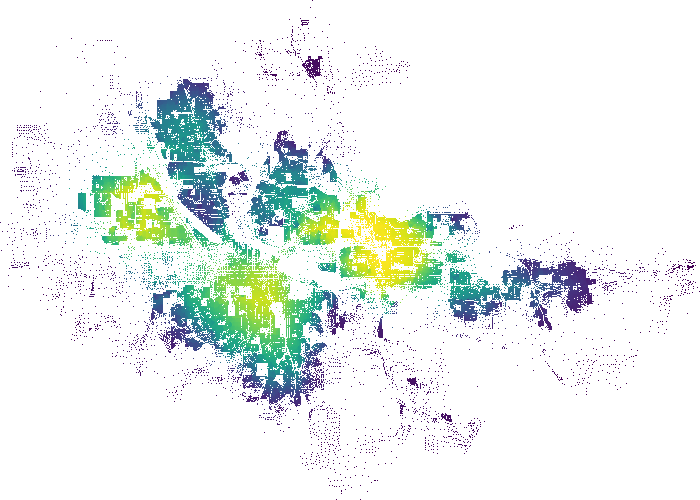

In [13]:
variable_name = 'du_5km'
parcels[variable_name] = misc.reindex(results, parcels.node_id)

cvs = ds.Canvas(plot_width=700, plot_height=500)
agg = cvs.points(parcels, 'x', 'y', ds.mean(variable_name))
img = tf.set_background(tf.shade(agg, cmap=viridis),"white")
img